# Preparing the reads

[Loose et al] published their raw read files on ENA. This script uses four of these sets which contain reads of amplicons. These were processed using different "read until" scripts (or none at all), but that doesn't matter. What does matter is to get as much real reads as possible.

In [2]:
%load_ext autoreload
%autoreload 2

In [288]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import porekit
import re
import pysam
import random
import feather
%matplotlib inline

## Load metadata for 4 datasets

In [69]:
directories = ["AmpliconOddEvenControl", "AmpliconOddReadUntil", "AmpliconEvenReadUntil", "Balanced"]

In [70]:
meta_frames = []
for d in directories:
    print(d)
    df = porekit.gather_metadata("/home/andi/nanopore/%s" % d, workers=4)
    print(df.shape[0])
    meta_frames.append(df)

AmpliconOddEvenControl
7576
AmpliconOddReadUntil
25999
AmpliconEvenReadUntil
20032
Balanced
24386


In [261]:
meta = pd.concat (meta_frames)

In [213]:
for df in meta_frames:
    print (df.shape)

(7576, 27)
(25999, 27)
(20032, 27)
(24386, 27)


The individual filenames will look like this:

In [214]:
meta_frames[0].index.values[0]

'llssbzms2p35x_20151005_readuntilnorm_RU24_lambdaPCR_4713_1_ch475_file3_strand.fast5'

In [215]:
meta_frames[1].index.values[0]

'llssbzms2p35x_20151004_readuntiludududududu_RU21_lambdaPCR_2922_1_ch7_file74_strand.fast5'

In [216]:
meta_frames[2].index.values[0]

'llssbzms2p35x_20151004_readuntildududududud_RU22_lambdaPCR_4117_1_ch9_file62_strand.fast5'

In [217]:
meta_frames[3].index.values[0]

'PLSP57501_lambda_200xRU_5027_1_ch95_file50_strand.fast5'

## Merging alignment data

[Loose et al] provide all the intermediate data files necessary to recreate their figures. Among these, there are some alignment files in SAM format.

Because it doesn't make sense to classify complement sequences/matches in the Read Until context, we only use the "Template" strands.

In [262]:
def sam_to_dataframe(file_name):
    sam = pysam.AlignmentFile(file_name)
    records = []
    for i, segment in enumerate(sam):
        d = dict()
        for k in ["query_name", "reference_start", "reference_end", "mapping_quality", ]:
            d[k] = getattr(segment, k)
        records.append(d)
    alignments = pd.DataFrame.from_records(records)
    return alignments

In [263]:
base  = "/home/andi/nanopore/RUFigs/data"
bams = ["/fig3/RU_dudu/RU_dudu_Template.bam",
        "/fig3/RU_udud/RU_udud_Template.bam",
        "/fig3/NO_RU/NO_RU_Template.bam",
        "/fig4/200/200_Template.bam",
        ]
alignments = pd.concat([sam_to_dataframe(base+file_name) for file_name in bams])

Unfortunately filenames and sequence names tend to get a bit mangled when going from Fast5 to SAM, for various reasons. As of now, there is no particular convention for naming read files or naming the exported sequences. On the one hand I don't feel like it is a good idea to abuse filenames as character seperated database rows, on the other hand, using the unique read id from the Fast5 File isn't very human-friendly either.

To assign genomic coordinates to the reads, a regular expression extracts four numbers from the file name/query name  making each read unique and matchable.

In [264]:
regexp = re.compile(r'_(?P<a>\d+)_(?P<b>\d+)_ch(?P<c>\d+)_file(?P<d>\d+)')
def extract(s):
    try:
        return "_".join(regexp.search(s).groups())
    except:
        return ""
alignments["alignment_key"] = alignments.query_name.map(extract)
meta["alignment_key"] = meta.index.map(extract)
alignments["alignment_key"].map(lambda s: s.split("_")[0]).unique()
meta["run_number"] = meta["alignment_key"].map(lambda s: s.split("_")[0])

In [265]:
meta2 = meta.reset_index().merge(alignments).set_index("filename")
meta2.shape

(48024, 33)

In [268]:
meta = meta2

## Visualizing the alignments

This is just a simple histogram showing where the "reference_start" values fall.

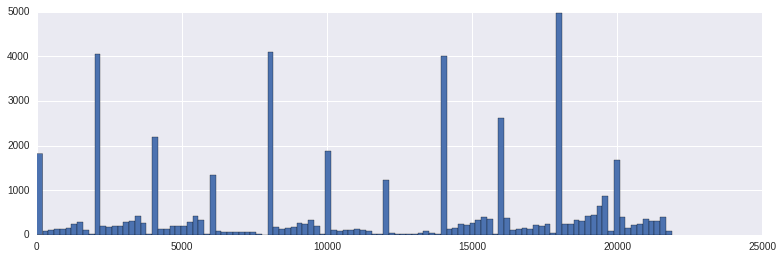

In [269]:
f, ax = plt.subplots()
f.set_figwidth(13)
ax.hist(meta.reference_start, bins=110);

## Processing the amplicons

[Loose et al] pooled 11 amplicons. Each read has to be assigned retroactively to one of these, represented by number from 0 to 10.

In [274]:
amplicons = [(52,1980),
             (2065,3965),
             (4070,5989),
             (6059,7981),
             (8012,9947),
             (10008,11963),
             (12006,13941),
             (14011,15945),
             (16076,17987),
             (18022,19972),
             (20053,21979),
            ]
def amplicon_from_position(pos):
    for i,c in enumerate(amplicons):
        a,b = c
        if a<=pos<=b:
            return i
meta["amplicon"] = meta.reference_start.map(amplicon_from_position)


How many reads failed to be assigned?

In [275]:
meta.amplicon.isnull().sum()

11622

Purge these:

In [280]:
meta = meta[np.isnan(meta.amplicon)==False]
meta.shape

(36402, 34)

The number of viable reads is diminishing quickly. But this can't be helped.

How many reads longer than 500 bases are assigned to each amplicon?

In [277]:
meta.query("template_length>500").groupby("amplicon").format.count()

amplicon
0.0     1080
1.0     2475
2.0     1241
3.0      997
4.0     2194
5.0     1221
6.0      635
7.0     2503
8.0     2006
9.0     4018
10.0    1854
Name: format, dtype: int64

Unfortunately some amplicons are severely underrepresented, with one going as low as 635 reads.

This is a big problem for dividing the data into training and test sets, because blindly sampling from total pool may skew this balance even further. The algorithms will then bias against the least represented amplicons to gain a bit of extra accuracy, which is not what we want. With ten times as much data we could balance both the training and the test set. As it is, I chose to balance the test set only, to get a more realistic view of the performance. My assumption is that, over multiple repetitions of amplification / library preparation and sequencing runs, the amplicons should be roughly equally distributed.

To balance the test set, 200 reads from each amplicon are chosen. This makes for a very weak test set. But again, this can't be helped at this point.

In [308]:
sufficient = meta.query("template_length>=500")
all_files = sufficient.index.values
test_files = []
for i in range(11):
    sub = sufficient[sufficient.amplicon==i]
    test_files += list(np.random.choice(sub.index.values, 200))
    
training_files = list(set(sufficient.index.values) - set(test_files))
len(training_files), len(test_files)

(17831, 2200)

In [309]:
test_data = sufficient.ix[np.array(test_files)]
feather.write_dataframe(test_data, "amplicon_test_metadata.feather")

training_data = sufficient.ix[np.array(training_files)]
feather.write_dataframe(training_data, "amplicon_training_metadata.feather")